<a href="https://www.kaggle.com/code/elifnurylmaz/tw-sentiment-analysis-preprocessing-naivebayes?scriptVersionId=265672142" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


öncelikle gerekli tüm kütüphaneleri import ederek ve gerekli yüklemeleri yaparak başlıyorum 

In [2]:
!pip install wordsegment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 52.9 MB/s eta 0:00:00


In [3]:
# Temel Bilimsel Hesaplama
from warnings import filterwarnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Ön İşleme
import re,string
import nltk
from nltk.corpus import stopwords


from nltk.tokenize import TweetTokenizer

from nltk.corpus import stopwords
from wordsegment import load, segment
import spacy
from textblob import TextBlob, Word
import gensim
from gensim import corpora

# Özellik Çıkarma (Vectorizer vb.)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ML Modelleri
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Görselleştirme
from wordcloud import WordCloud

# Yardımcı Araçlar
from tqdm import tqdm
import os
import pickle


In [4]:
import nltk
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("averaged_perceptron_tagger")   # bazı sürümlerde hala bu lazım oluyor
nltk.download("wordnet")
nltk.download("stopwords")


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", header=None)

In [6]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
df.columns = ["label", "time", "date", "query", "username", "text"]

In [8]:
df.head()

,label,time,date,query,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1600000 non-null  int64 
 1   time      1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   username  1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [10]:
df["label"].isna().sum()

0

In [11]:
# Her label'dan kaç tane var
print(df["label"].value_counts())

# Oranlarını da görmek için:
print(df["label"].value_counts(normalize=True))

#0 means negatif and 4 means pozitif 

label
0    800000
4    800000
Name: count, dtype: int64
label
0    0.5
4    0.5
Name: proportion, dtype: float64


change 4 with 1 for binary classification

In [12]:
df["label"] = df["label"].replace(4, 1)


In [13]:
df = df[["label", "text"]]

In [14]:
df.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


data preprocessing process:

hangi aşamaları uygulayacağız: 
1. tüm kütüphaneleri import et
2. preprocess için gerekli bir fonksiyon yaz preporcessing de ne yapacağız:
   - lower
   - sayıları çıkar
   - noktalama işareti çıkar
   - url çıkar
   - username leri çıkar
   - emojiler konusunda nasıl bir yol izlemeliyim? (emoji içermiyor) bir çalışma yapmamıza gerek yok. 

In [15]:
# Text sütununda emoji veya özel karakter var mı görmek için
import re

def contains_emoji(s):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(s))

# Kaç tweet emoji içeriyor?
print(df["text"].apply(contains_emoji).value_counts())


text
False    1600000
Name: count, dtype: int64


In [16]:
df.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [17]:
stop_words = set(stopwords.words("english"))
print(stop_words)

{'who', "mightn't", 'and', 've', 'very', 'shan', 'some', 'what', 'each', 'no', "they're", 'now', 'other', 'there', 'its', 'couldn', "i'm", 'she', 'further', "i've", 'have', 'more', "they've", 'weren', 'having', 'in', 'ain', "i'll", 'than', 'doing', 'with', 'should', "shouldn't", 'won', 'down', 'under', "she'll", 'by', 'how', 'll', 'of', "should've", 'are', "weren't", 'we', 'from', 'herself', 'or', 'to', 'which', 'when', 'a', 'ourselves', 'they', "mustn't", 'haven', 'yours', "isn't", 'myself', "he'd", 'those', 'don', "wasn't", 'doesn', 'such', 'nor', 't', "she'd", 'above', 'on', "we'll", 'through', "you'll", 'for', 'only', "he'll", 'into', 'their', 'at', "hadn't", "it's", 'if', 'his', 'an', 'isn', 'does', "we'd", 're', 'd', 'the', 'out', 'will', "needn't", 'did', "don't", 'where', 'was', 'before', 'didn', 'after', 'during', "haven't", 'yourself', 's', 'mustn', 'that', 'but', 'again', 'hers', 'm', 'it', 'your', "didn't", 'he', 'until', "she's", 'both', "doesn't", 'whom', 'own', "wouldn't

In [18]:
stop_words = set(stopwords.words("english"))

# WordSegment'i hashtag splitting için yükle
load()

tk = TweetTokenizer(reduce_len=True, strip_handles=True)

# Slang dictionary (kısaltmalar)
slang_map = {
    "u": "you", "r": "are", "idk": "i_do_not_know", "smh": "shaking_my_head",
    "imo": "in_my_opinion", "pls": "please", "plz": "please", "ur": "your"
}

# 1. Tekrar eden harfleri normalize et
def normalize_repeated_chars(text):
    return re.sub(r"(.)\1{2,}", r"\1", text)

# 2. Negation handling
def handle_negations(text):
    return re.sub(r"\bnot\s+(\w+)", r"not_\1", text)

# 3. Hashtag splitter
def split_hashtag(token):
    if token.startswith("#"):
        return " ".join(segment(token[1:]))
    return token

# Ana preprocessing fonksiyonu
def preprocess_tweet(text: str) -> str:
    # Lowercase
    text = text.lower()

    # URL ve sayıları kaldır
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\d+", "", text)
    
    # Noktalama normalize
    text = re.sub(r"([!?])\1+", r"\1", text)

    # Negation handling
    text = handle_negations(text)

    # Tokenization
    tokens = tk.tokenize(text)

    cleaned = []
    for w in tokens:
        w = normalize_repeated_chars(w)       # loveee → love
        w = split_hashtag(w)                  # #BestDayEver → best day ever
        if w in slang_map: 
            w = slang_map[w]                  # slang conversion
        if w not in stop_words and re.match(r"\w+", w):  
            cleaned.append(Word(w).lemmatize())

    return " ".join(cleaned)


In [19]:
tweet = "@user I loveee this movie!! 😍😍 It's soooo good!!! Visit http://movie.com #Awesome"
print(preprocess_tweet(tweet))


love movie good visit awesome


In [20]:
df["clean_text"] = df["text"].apply(preprocess_tweet)


In [21]:
df.head()

,label,text,clean_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",that's bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset can't update facebook texting might cry ...
2,0,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save rest go bound
3,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",not_behaving mad can't see


In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(texts, title="WordCloud", max_words=200, 
                   background_color="white", colormap="viridis", save_path=None):
    """
    texts: pandas Series (ör: df["clean_text"])
    save_path: string, kaydedilecek dosya adı (ör: "wordcloud.png")
    """
    text = " ".join(texts)
    wc = WordCloud(width=800, height=400, background_color=background_color,
                   colormap=colormap, max_words=max_words).generate(text)
    
    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()
    
    # Eğer save_path verilirse kaydet
    if save_path:
        wc.to_file(save_path)
        print(f"✅ WordCloud kaydedildi: {save_path}")


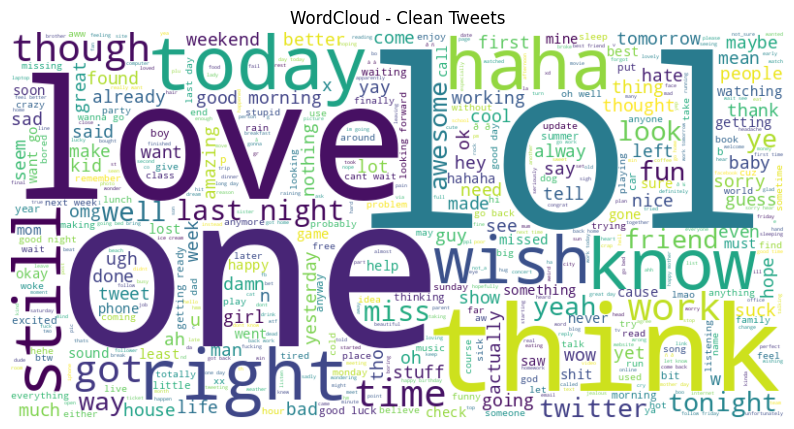

✅ WordCloud kaydedildi: wordcloud_clean.png


In [23]:
plot_wordcloud(df["clean_text"], max_words=500, title="WordCloud - Clean Tweets", save_path="wordcloud_clean.png")


naive bayes modeli:

train test split

In [24]:
from sklearn.model_selection import train_test_split

X = df["clean_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [25]:
X.head()

0       that's bummer shoulda got david carr third day
1    upset can't update facebook texting might cry ...
2      dived many time ball managed save rest go bound
3                      whole body feel itchy like fire
4                           not_behaving mad can't see
Name: clean_text, dtype: object

In [26]:
from collections import Counter

def get_rare_words(corpus, min_freq=2):
    """
    Tüm corpus'tan kelime frekanslarını hesaplayıp nadir kelimeleri döner.
    """
    all_words = " ".join(corpus).split()
    word_freq = Counter(all_words)
    rare_words = {w for w, c in word_freq.items() if c < min_freq}
    print(f"{len(rare_words)} rare words found (freq < {min_freq})")
    return rare_words


In [27]:
rare_words = get_rare_words(X_train, min_freq=2)


152940 rare words found (freq < 2)


In [28]:
def remove_rare_words(corpus, rare_words):
    """
    rare_words: set (train'den çıkarılmış nadir kelimeler)
    """
    cleaned_corpus = corpus.apply(
        lambda x: " ".join([w for w in x.split() if w not in rare_words])
    )
    return cleaned_corpus


In [29]:
X_train = remove_rare_words(X_train, rare_words)
X_test  = remove_rare_words(X_test, rare_words)


In [30]:
print("Örnek train satırı:", X_train.iloc[0][:200])
print("Örnek test satırı:", X_test.iloc[0][:200])


Örnek train satırı: lol get idea far advance not_even june yet need third knitter summer group
Örnek test satırı: yes black red fav color really wanted color def look awesome jared



=== Count + Naive Bayes ===
Accuracy: 0.7738
              precision    recall  f1-score   support

           0       0.77      0.78      0.78    160000
           1       0.78      0.77      0.77    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



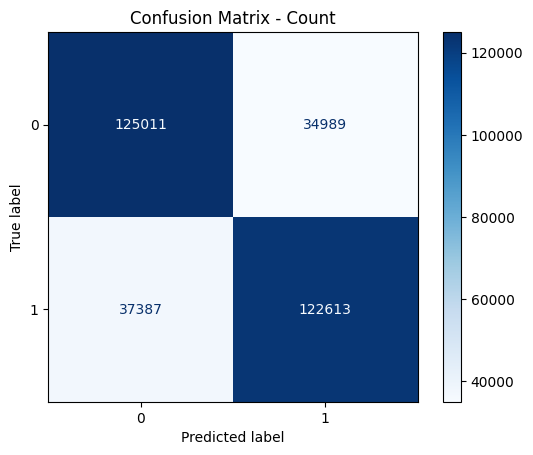


=== TF-IDF + Naive Bayes ===
Accuracy: 0.7680
              precision    recall  f1-score   support

           0       0.76      0.77      0.77    160000
           1       0.77      0.76      0.77    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



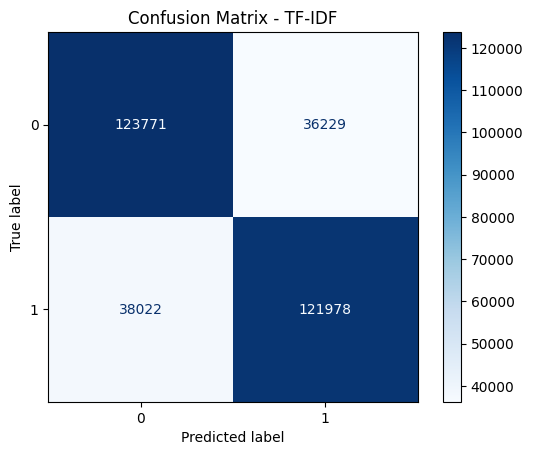


>>> En iyi vectorizer: Count (Accuracy = 0.7738)


In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Dictionary (model sonuçlarını saklamak için)
results = {}

for vect_name, vect in [("Count", CountVectorizer()), ("TF-IDF", TfidfVectorizer())]:
    pipe = Pipeline([
        ("vectorizer", vect),
        ("nb", MultinomialNB())
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    
    results[vect_name] = (pipe, acc, y_pred)
    
    print(f"\n=== {vect_name} + Naive Bayes ===")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    
    ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap="Blues")
    plt.title(f"Confusion Matrix - {vect_name}")
    plt.show()

# En iyi vectorizer'ı seç
best_vect_name = max(results, key=lambda k: results[k][1])
print(f"\n>>> En iyi vectorizer: {best_vect_name} (Accuracy = {results[best_vect_name][1]:.4f})")


In [32]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Count mu TF-IDF mi?
chosen_vect = CountVectorizer() if best_vect_name == "Count" else TfidfVectorizer()

pipe = Pipeline([
    ("vectorizer", chosen_vect),
    ("nb", MultinomialNB())
])

param_dist = {
    "vectorizer__ngram_range": [(1,1), (1,2)],
    "vectorizer__min_df": [1, 2, 5],
    "vectorizer__max_df": [0.9, 0.95, 1.0],
    "nb__alpha": np.logspace(-2, 2, 30),  # 0.01 → 100
    "nb__fit_prior": [True, False]
}

rand_search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=25,
    scoring="accuracy",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rand_search.fit(X_train, y_train)

print("\n=== Fine Tuning Results ===")
print("Best Params:", rand_search.best_params_)
print(f"Best CV Score: {rand_search.best_score_:.4f}")


Fitting 3 folds for each of 25 candidates, totalling 75 fits

=== Fine Tuning Results ===
Best Params: {'vectorizer__ngram_range': (1, 2), 'vectorizer__min_df': 5, 'vectorizer__max_df': 0.95, 'nb__fit_prior': True, 'nb__alpha': 5.736152510448681}
Best CV Score: 0.7811



=== Test Set Performance ===
Accuracy: 0.784153125
              precision    recall  f1-score   support

           0       0.78      0.79      0.79    160000
           1       0.79      0.78      0.78    160000

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



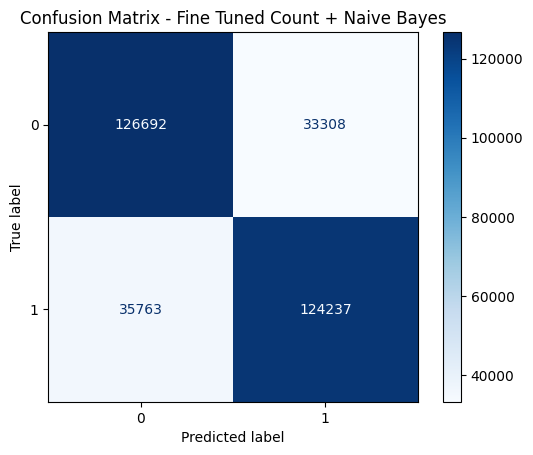

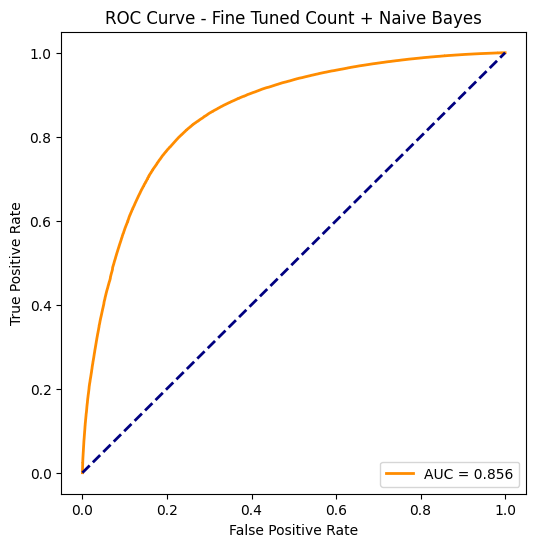

In [33]:
from sklearn.metrics import roc_curve, auc

# En iyi modelle test setinde tahmin yap
best_model = rand_search.best_estimator_
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

print("\n=== Test Set Performance ===")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues")
plt.title(f"Confusion Matrix - Fine Tuned {best_vect_name} + Naive Bayes")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - Fine Tuned {best_vect_name} + Naive Bayes")
plt.legend(loc="lower right")
plt.show()



=== Classification Report ===


,precision,recall,f1-score,support
0,0.780,0.792,0.786,160000.000000
1,0.789,0.776,0.782,160000.000000
accuracy,0.784,0.784,0.784,0.784153
macro avg,0.784,0.784,0.784,320000.000000
weighted avg,0.784,0.784,0.784,320000.000000



=== Confusion Matrix (Numeric) ===
[[126692  33308]
 [ 35763 124237]]


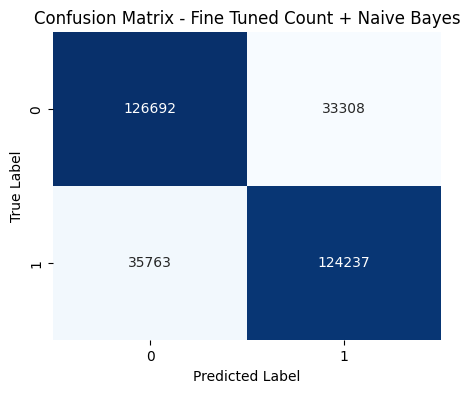

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# === 1️⃣ Classification Report (Tablo formatında) ===
print("\n=== Classification Report ===")
report_dict = classification_report(y_test, y_pred_best, output_dict=True)
report_df = pd.DataFrame(report_dict).T

# Precision, Recall, F1 ve Support değerlerini tablo halinde göster
display(report_df.style.background_gradient(cmap="YlGnBu").format({"precision":"{:.3f}", "recall":"{:.3f}", "f1-score":"{:.3f}"}))

# === 2️⃣ Confusion Matrix (Sayısal ve Görsel) ===
cm = confusion_matrix(y_test, y_pred_best)
print("\n=== Confusion Matrix (Numeric) ===")
print(cm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix - Fine Tuned {best_vect_name} + Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


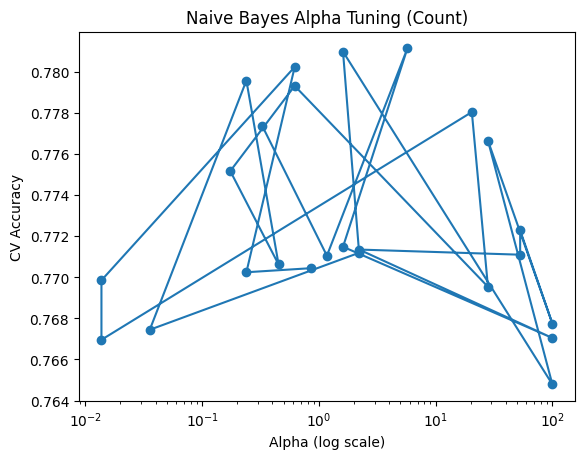

In [35]:
results_df = pd.DataFrame(rand_search.cv_results_)
plt.semilogx(results_df["param_nb__alpha"], results_df["mean_test_score"], "o-")
plt.xlabel("Alpha (log scale)")
plt.ylabel("CV Accuracy")
plt.title(f"Naive Bayes Alpha Tuning ({best_vect_name})")
plt.show()



=== Count + Naive Bayes ===
Accuracy: 0.773825
              precision    recall  f1-score   support

           0       0.77      0.78      0.78    160000
           1       0.78      0.77      0.77    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



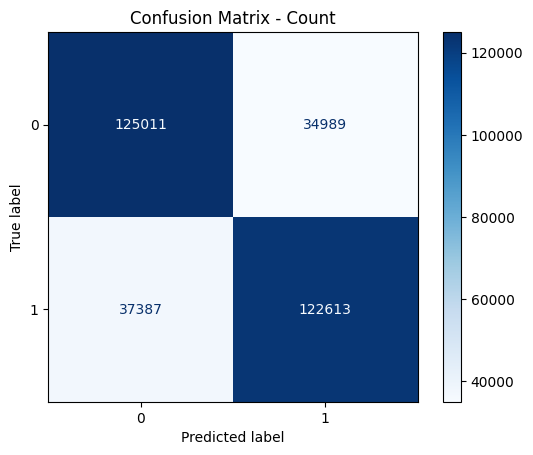


=== TFIDF + Naive Bayes ===
Accuracy: 0.767965625
              precision    recall  f1-score   support

           0       0.76      0.77      0.77    160000
           1       0.77      0.76      0.77    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



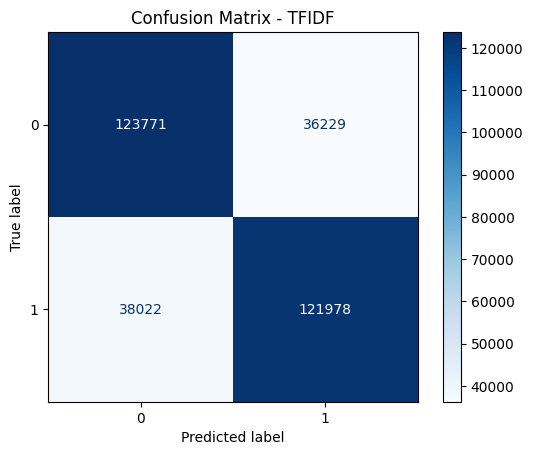

Fitting 3 folds for each of 10 candidates, totalling 30 fits

=== Fine Tuning (TF-IDF + NB) ===
Best Params: {'TFIDF__ngram_range': (1, 2), 'nb__alpha': 5}
Best CV Score: 0.7826023443454382
Test Accuracy: 0.78558125
              precision    recall  f1-score   support

           0       0.77      0.81      0.79    160000
           1       0.80      0.76      0.78    160000

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



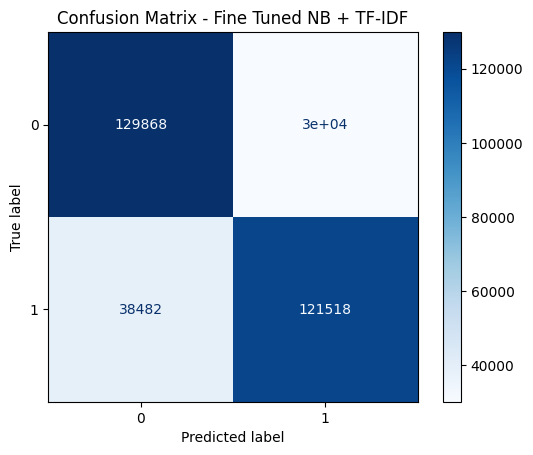

In [36]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# 2. MODELLERİ DENE
results = {}

for vect_name, vect in [("Count", CountVectorizer()), ("TFIDF", TfidfVectorizer())]:
    pipe = Pipeline([
        (vect_name, vect),
        ("nb", MultinomialNB())
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[vect_name] = (pipe, acc, y_pred)
    print(f"\n=== {vect_name} + Naive Bayes ===")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap="Blues")
    plt.title(f"Confusion Matrix - {vect_name}")
    plt.show()

# 3. FINE TUNING (sadece TF-IDF üzerinde)
param_grid = {
    "TFIDF__ngram_range": [(1,1), (1,2)],
    "nb__alpha": [0.1, 0.5, 1, 5, 10]
}
pipe_tfidf = Pipeline([
    ("TFIDF", TfidfVectorizer()),
    ("nb", MultinomialNB())
])

grid = GridSearchCV(pipe_tfidf, param_grid, cv=3, n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

print("\n=== Fine Tuning (TF-IDF + NB) ===")
print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)
y_pred_best = grid.best_estimator_.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, X_test, y_test, cmap="Blues")
plt.title("Confusion Matrix - Fine Tuned NB + TF-IDF")
plt.show()


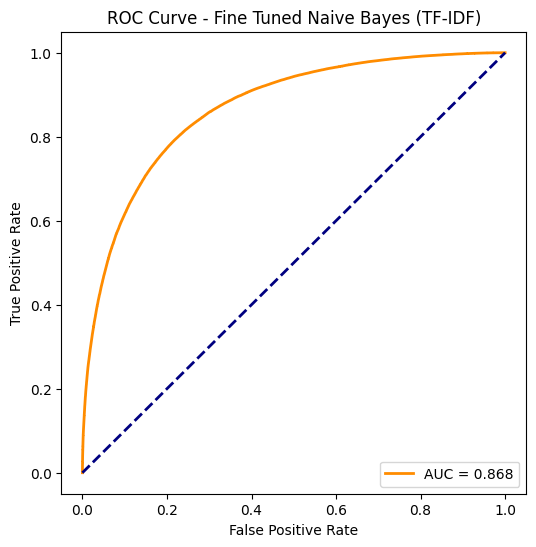

In [37]:
from sklearn.metrics import roc_curve, auc

# ROC için probability skorlarını alıyoruz
y_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Fine Tuned Naive Bayes (TF-IDF)")
plt.legend(loc="lower right")
plt.show()
